# Facial Keypoints Detection#

## Author: Angelo Antonio Manzatto ##

------------------------

### Project Objectives ###

Facial keypoints detections is an important problem in computer vision field used on the following tasks:
* Facial tracking
* Facial pose recognition 
* Facial filters
* Emotion recognition

### Project Pipeline ###

* Load Dataset
* Process Dataset
* Create Model
* Train
* Evaluate
* Test on video

---------------------------

The databased used for this project was provided by #Udacity# provided on the following link: https://github.com/udacity/P1_Facial_Keypoints

The base model used for this project was based on the following paper: https://arxiv.org/pdf/1710.00977.pdf

The two test videos for this project were use from the dataset stored  site here where I will put a reference for their work:

[1] M. Kim, S. Kumar, V. Pavlovic, and H. Rowley, “Face Tracking and Recognition with Visual Constraints in Real-World Videos,” in IEEE Conf. Computer Vision and Pattern Recognition, Anchorage, AK, 2008. 

web page: http://seqamlab.com/youtube-celebrities-face-tracking-and-recognition-dataset/

![image](images/key_pts_example.png)

In [1]:
##################################################################################
# Libraries
##################################################################################  

import os
import copy
import csv
import random
import numpy as np

import matplotlib.pyplot as plt

import cv2

from keras.models import Sequential

from keras.layers import Dropout, Dense, Flatten, Reshape, Lambda
from keras.layers import Conv2D,  MaxPooling2D 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, CSVLogger

from moviepy.editor import VideoFileClip

Using TensorFlow backend.


In [2]:
############################################################################################
# Files and folders and default parameters
############################################################################################

data_folder = "data"
training_folder = os.path.join(data_folder,"training" )
test_folder = os.path.join(data_folder,"test" )

training_keypoints_file = os.path.join(data_folder,'training_frames_keypoints.csv')
test_keypoints_file = os.path.join(data_folder,'test_frames_keypoints.csv')

In [3]:
############################################################################################
# Load data
############################################################################################
def load_data(keypoints_file, image_folder):

    data = []
    with open(keypoints_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            # Skip header
            if line_count > 0:
                
                # Get image name
                image_path = os.path.join(image_folder,row[0])
                
                # Get a list of x,y coordinates
                key_pts = row[1:]
                
                # Calculane total number of coordinates. This is supposed to not vary for each sample
                n_points = int(len(key_pts) / 2)
                
                # Convert list of coordinates into a matrix of size (n_coords, 2)
                key_pts = np.asarray(key_pts).reshape((n_points,2)).astype('float')
                
                data.append((image_path, key_pts))
                
            line_count +=1
            
    return data

In [4]:
# Load and split data into train / test / validation sets 
train_test_data = load_data(training_keypoints_file,training_folder)
valid_data = load_data(test_keypoints_file,test_folder)
train_data, test_data = train_test_split(train_test_data, test_size=0.20, random_state=42)

print('Size of train data: {0}'.format(len(train_data)))
print('Size of test data: {0}'.format(len(test_data)))
print('Size of valid data: {0}'.format(len(valid_data)))

Size of train data: 2769
Size of test data: 693
Size of valid data: 770


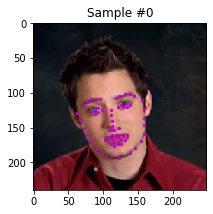

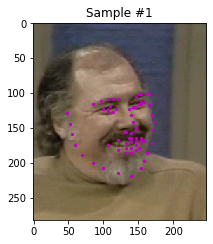

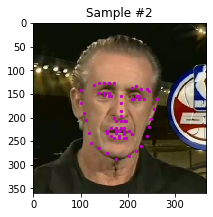

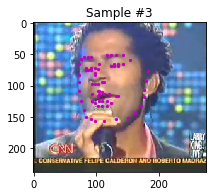

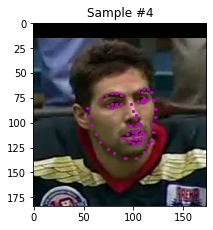

In [5]:
############################################################################################
# Show data
############################################################################################

# Display a few of the images from the dataset
n_samples = 5
    
for i in range(n_samples):
    
    # define the size of images
    fig = plt.figure(figsize=(18,12))
    
    # randomly select a sample
    idx = np.random.randint(0, len(train_data))
    sample = train_data[idx]
    
    ax = plt.subplot(1, n_samples, i + 1)
    ax.set_title('Sample #{}'.format(i))
                 
    image_path, key_pts = sample
    
    image = plt.imread(image_path)
    
    plt.imshow(image)
    
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [6]:
############################################################################################
# Data Augmentation 
############################################################################################

In [7]:
#############################
# Resize Image
#############################
class Resize(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image, key_pts = None):
        
        # Get image shape
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)

        image = cv2.resize(image, (new_w, new_h))

        if key_pts is not None:
            
            new_key_pts = copy.deepcopy(key_pts)

            for k_p in new_key_pts:
                k_p[0] = k_p[0] * new_w / w
                k_p[1] = k_p[1] * new_h / h
                
            return image, new_key_pts
        
        return image, key_pts

In [8]:
#############################
# Translate Image
#############################    
class RandomTranslation(object):

    def __init__(self, ratio = 0.4, background_color = (0,0,0,255) , prob=0.5):
        
        self.background_color  = background_color
        self.ratio = ratio
        self.prob  = prob
        
    def __call__(self, image, key_pts):
                
        if random.uniform(0, 1) <= self.prob:
            
            img_h, img_w, img_c = image.shape
            
            x = int(np.random.uniform(-self.ratio,self.ratio) * img_w)
            y = int(np.random.uniform(-self.ratio,self.ratio) * img_h)

            M = np.float32([[1, 0, x],
                            [0, 1, y]])
                
            image_translated = cv2.warpAffine(image,M,(img_w,img_h), borderValue=self.background_color)
            
            new_key_pts = np.zeros_like(key_pts)
                
            new_key_pts[:,0] = key_pts[:,0] + x
            new_key_pts[:,1] = key_pts[:,1] + y

            return image_translated.astype("uint8") , new_key_pts
           
        return image, key_pts

In [9]:
#############################
# Scale Image
#############################  
class RandomScale(object):

    def __init__(self, lower = 0.4,upper = 1.4, background_color = (0,0,0,255) , prob=0.5):
        
        self.background_color = background_color
        self.lower = lower
        self.upper = upper
        self.prob  = prob  
        
    def __call__(self, image, key_pts):
                
        if random.uniform(0, 1) <= self.prob:
            
            img_h, img_w, img_c = image.shape
            
             # Create canvas with random ration between lower and upper
            ratio = random.uniform(self.lower,self.upper)
            
            scale_x = ratio
            scale_y = ratio
            
            # Scale the image
            scaled_image = cv2.resize(image.astype('float32'),(0,0),fx=scale_x,fy=scale_y)
            
            top = 0
            left = 0
            
            if ratio < 1:
                    
                background = np.zeros((img_h, img_w, img_c), dtype = np.uint8)
                
                background[:,:,:] = self.background_color 
            
                y_lim = int(min(scale_x,1)*img_h)
                x_lim = int(min(scale_y,1)*img_w)
                
                top  = (img_h - y_lim) // 2
                left = (img_w - x_lim) // 2

                background[top:y_lim+top,left:x_lim+left,:] = scaled_image[:y_lim,:x_lim,:]
                
                scaled_image = background
                    
            else:
                
                top  = (scaled_image.shape[0] -  img_h) // 2
                left = (scaled_image.shape[1] -  img_w) // 2
                
                scaled_image = scaled_image[top:img_h+top,left:img_w+left,:]
                
            # Correct key pts coordinates
            new_key_pts = np.zeros_like(key_pts)
            
            if ratio > 1:
                new_key_pts[:,0] = key_pts[:,0] * scale_x - left
                new_key_pts[:,1] = key_pts[:,1] * scale_y - top
            else:
                new_key_pts[:,0] = key_pts[:,0] * scale_x + left
                new_key_pts[:,1] = key_pts[:,1] * scale_y + top 
                
            return scaled_image.astype("uint8"), new_key_pts

        return image, key_pts

In [10]:
#############################
# Flip image
#############################    
class RandomFlip(object):
 
    def __init__(self, prob=0.5):

        self.prob = prob
        
    def __call__(self, image, key_pts= None):
        
        if random.uniform(0, 1) <= self.prob:
        
            # Get image shape
            h, w = image.shape[:2]
            
            # Flip image
            image = image[:, ::-1]

            if key_pts is not None:
                
                new_key_pts = copy.deepcopy(key_pts)
                
                new_key_pts[:,0] = w - key_pts[:,0]
                
                # We have to do a mapping between each point of left face to the right face
                # Brute force
                new_key_pts_flipped = np.zeros_like(new_key_pts)
                
                new_key_pts_flipped[0] = new_key_pts[16]
                new_key_pts_flipped[1] = new_key_pts[15]
                new_key_pts_flipped[2] = new_key_pts[14]
                new_key_pts_flipped[3] = new_key_pts[13]
                new_key_pts_flipped[4] = new_key_pts[12]
                new_key_pts_flipped[5] = new_key_pts[11]
                new_key_pts_flipped[6] = new_key_pts[10]
                new_key_pts_flipped[7] = new_key_pts[9]
                new_key_pts_flipped[8] = new_key_pts[8]
                new_key_pts_flipped[9] = new_key_pts[7]
                new_key_pts_flipped[10] = new_key_pts[6]
                new_key_pts_flipped[11] = new_key_pts[5]
                new_key_pts_flipped[12] = new_key_pts[4]
                new_key_pts_flipped[13] = new_key_pts[3]
                new_key_pts_flipped[14] = new_key_pts[2]
                new_key_pts_flipped[15] = new_key_pts[1]
                new_key_pts_flipped[16] = new_key_pts[0]
                new_key_pts_flipped[17] = new_key_pts[26]
                new_key_pts_flipped[18] = new_key_pts[25]
                new_key_pts_flipped[19] = new_key_pts[24]
                new_key_pts_flipped[20] = new_key_pts[23]
                new_key_pts_flipped[21] = new_key_pts[22]
                new_key_pts_flipped[22] = new_key_pts[21]
                new_key_pts_flipped[23] = new_key_pts[20]
                new_key_pts_flipped[24] = new_key_pts[19]
                new_key_pts_flipped[25] = new_key_pts[18]
                new_key_pts_flipped[26] = new_key_pts[17]
                new_key_pts_flipped[27] = new_key_pts[27]
                new_key_pts_flipped[28] = new_key_pts[28]
                new_key_pts_flipped[29] = new_key_pts[29]
                new_key_pts_flipped[30] = new_key_pts[30]
                new_key_pts_flipped[31] = new_key_pts[35]
                new_key_pts_flipped[32] = new_key_pts[34]
                new_key_pts_flipped[33] = new_key_pts[33]
                new_key_pts_flipped[34] = new_key_pts[32]
                new_key_pts_flipped[35] = new_key_pts[31]
                new_key_pts_flipped[36] = new_key_pts[45]
                new_key_pts_flipped[37] = new_key_pts[44]
                new_key_pts_flipped[38] = new_key_pts[43]
                new_key_pts_flipped[39] = new_key_pts[42]
                new_key_pts_flipped[40] = new_key_pts[47]
                new_key_pts_flipped[41] = new_key_pts[46]
                new_key_pts_flipped[42] = new_key_pts[39]
                new_key_pts_flipped[43] = new_key_pts[38]
                new_key_pts_flipped[44] = new_key_pts[37]
                new_key_pts_flipped[45] = new_key_pts[36]
                new_key_pts_flipped[46] = new_key_pts[41]
                new_key_pts_flipped[47] = new_key_pts[40]
                new_key_pts_flipped[48] = new_key_pts[54]
                new_key_pts_flipped[49] = new_key_pts[53]
                new_key_pts_flipped[50] = new_key_pts[52]
                new_key_pts_flipped[51] = new_key_pts[51]
                new_key_pts_flipped[52] = new_key_pts[50]
                new_key_pts_flipped[53] = new_key_pts[49]
                new_key_pts_flipped[54] = new_key_pts[48]
                new_key_pts_flipped[55] = new_key_pts[59]
                new_key_pts_flipped[56] = new_key_pts[58]
                new_key_pts_flipped[57] = new_key_pts[57]
                new_key_pts_flipped[58] = new_key_pts[56]
                new_key_pts_flipped[59] = new_key_pts[55]
                new_key_pts_flipped[60] = new_key_pts[64]
                new_key_pts_flipped[61] = new_key_pts[63]
                new_key_pts_flipped[62] = new_key_pts[62]
                new_key_pts_flipped[63] = new_key_pts[61]
                new_key_pts_flipped[64] = new_key_pts[60]
                new_key_pts_flipped[65] = new_key_pts[67]
                new_key_pts_flipped[66] = new_key_pts[66]
                new_key_pts_flipped[67] = new_key_pts[65]
 
                return image, new_key_pts_flipped
            
        return image, key_pts  

In [11]:
#############################
# Blur image
#############################    
class RandomBlur(object):
    def __init__(self, lower = 1, upper = 5, prob=0.5):

        self.lower = lower
        self.upper = upper
        self.prob = prob
        
    def __call__(self, image, key_pts = None):
        
        if random.uniform(0, 1) <= self.prob:
            
            amount = random.randint(self.lower, self.upper)
            
            if(amount % 2 == 0):
                amount += 1 if random.random() < 0.5 else -1
           
            blur_image = cv2.GaussianBlur(image,(amount,amount),cv2.BORDER_DEFAULT)
            
            return blur_image, key_pts
        
        return image, key_pts

In [12]:
#############################
# Convert image to gray
#############################    
class ToGray(object):

    def __call__(self, image, key_pts = None):
        
        #Convert image to gray scale
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        
        gray = np.expand_dims(gray, axis=-1)
        
        return gray, key_pts

In [13]:
############################################################################################
# Test Data Augmentation 
############################################################################################
def plot_transformation(transformation, n_samples = 3):

    for i in range(n_samples):
    
        # define the size of images
        f, (ax1, ax2) = plt.subplots(1, 2)
        f.set_figwidth(14)

        # randomly select a sample
        idx = np.random.randint(0, len(train_data))
        image_path, key_pts = train_data[idx]

        image = plt.imread(image_path)

        new_image, new_key_pts = transformation(image, key_pts)
        
        if(image.shape[-1] == 1):
            ax1.imshow(np.squeeze(image), cmap = 'gray')
        else:
            ax1.imshow(image)
        ax1.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
        ax1.set_title('Original')

        if(new_image.shape[-1] == 1):
            ax2.imshow(np.squeeze(new_image), cmap = 'gray')
        else:
            ax2.imshow(new_image)
        ax2.scatter(new_key_pts[:, 0], new_key_pts[:, 1], s=20, marker='.', c='m')
        ax2.set_title(type(transformation).__name__)

        plt.show()

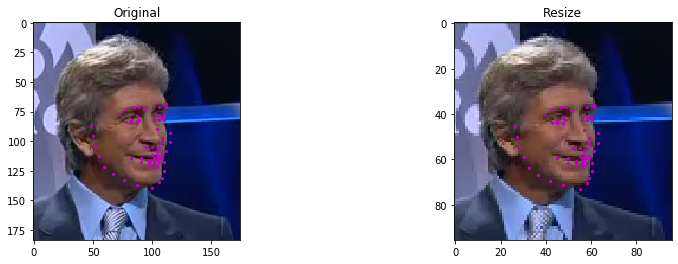

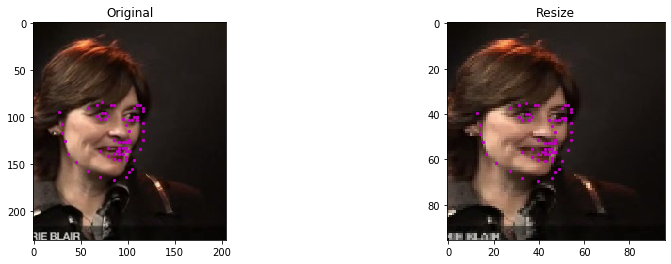

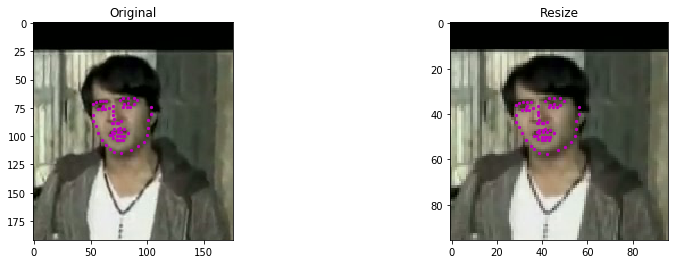

In [14]:
##########################
# Resize Test
##########################
resize = Resize((96, 96))
plot_transformation(resize)

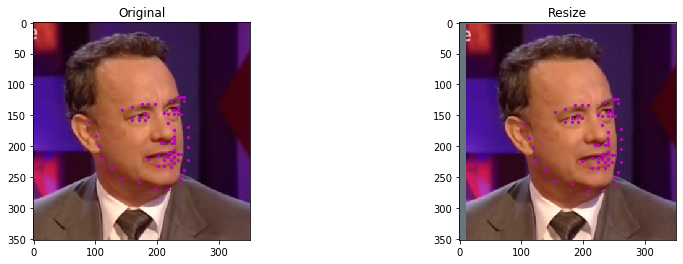

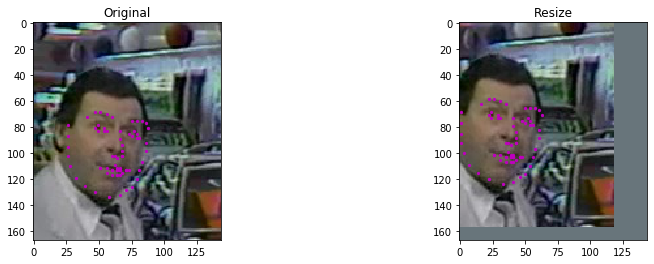

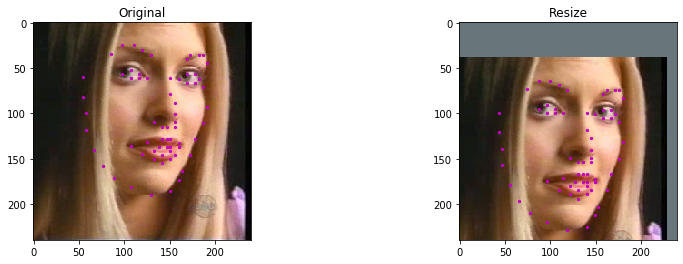

In [15]:
##########################
# Translation Test
##########################
random_translation = RandomTranslation(ratio=0.2,background_color=(104, 117, 123, 255),prob=1.0)
plot_transformation(random_translation)

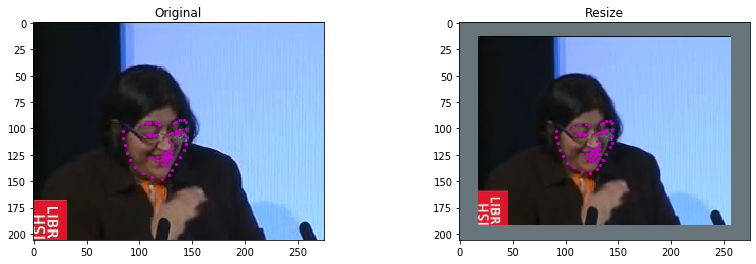

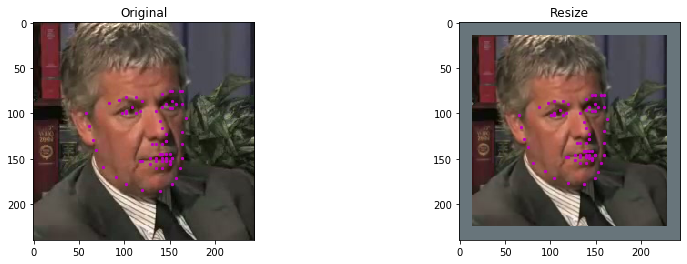

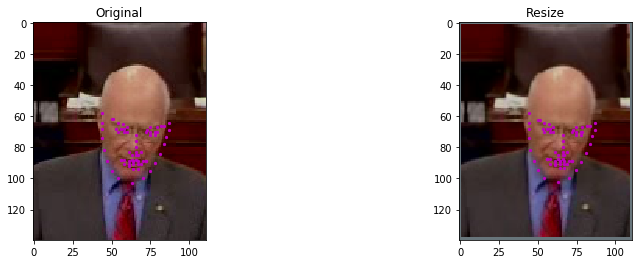

In [16]:
##########################
# Scale Test
##########################
random_scale = RandomScale(lower=0.6,upper=1.4,background_color=(104, 117, 123,255),prob=1.0)
plot_transformation(random_scale)

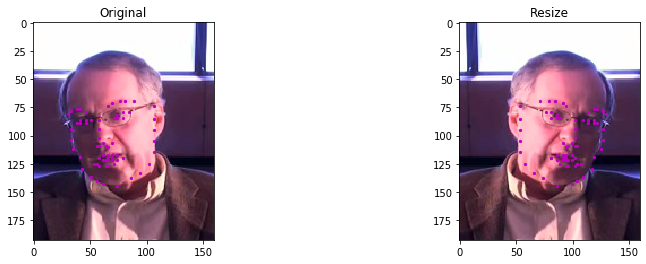

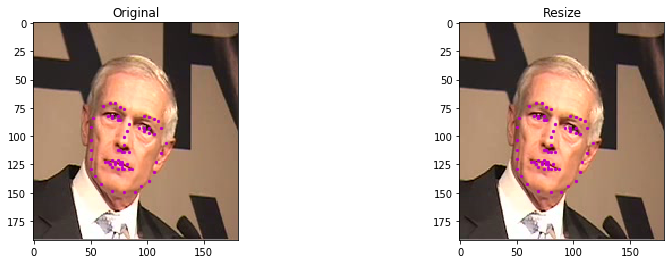

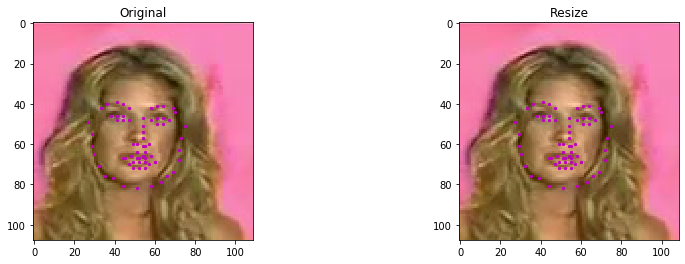

In [17]:
##########################
# Flip Test
##########################
random_flip = RandomFlip(prob=0.5)
plot_transformation(random_flip)

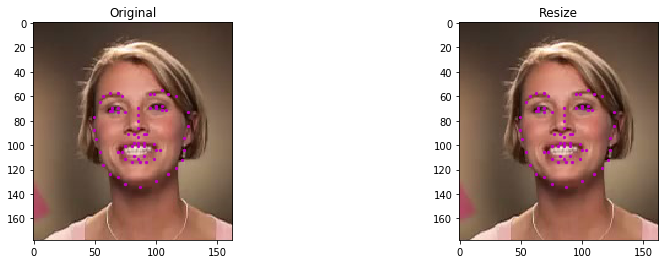

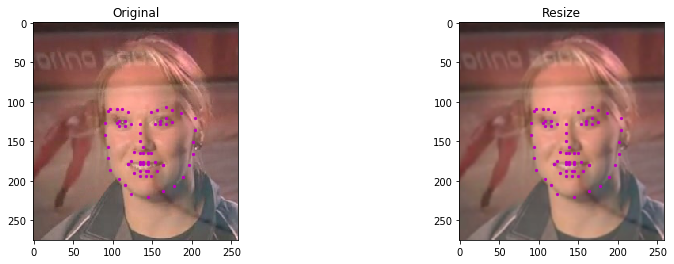

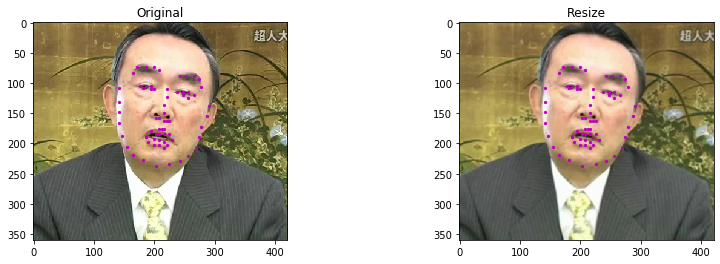

In [18]:
##########################
# Blur Test
##########################
random_blur = RandomBlur(prob=1.0)
plot_transformation(random_blur)

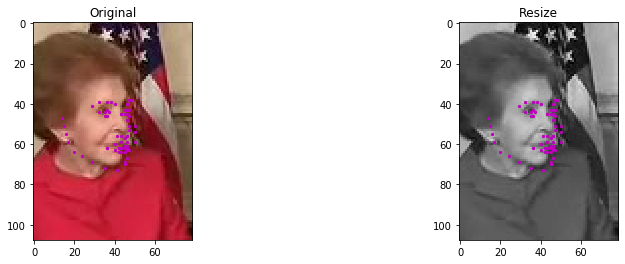

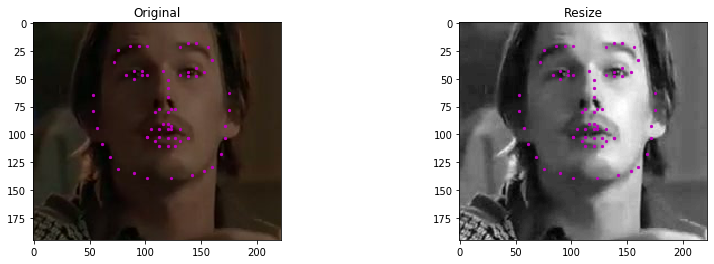

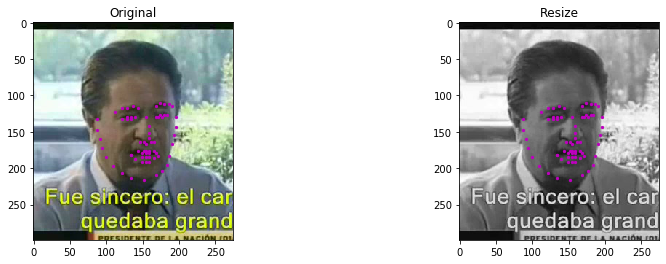

In [19]:
##########################
# Gray Test
##########################
to_gray = ToGray()
plot_transformation(to_gray)

In [20]:
############################################################################################
# Key Point operations
############################################################################################
def normalize_key_pts(key_pts, img_size):
    
    w, h = img_size
    
    half_w = w / 2
    half_h = h / 2
    
    new_key_pts = copy.deepcopy(key_pts)
    
    new_key_pts[:,0] = (new_key_pts[:,0] - half_w) / half_w
    new_key_pts[:,1] = (new_key_pts[:,1] - half_h) / half_h
    
    return new_key_pts
    
def denormalize_key_pts(key_pts, img_size):
    
    w, h = img_size
    
    half_w = w / 2
    half_h = h / 2
    
    new_key_pts = copy.deepcopy(key_pts)
    
    new_key_pts[:,0] = (new_key_pts[:,0] * half_w) + half_w
    new_key_pts[:,1] = (new_key_pts[:,1] * half_h) + half_h
    
    return new_key_pts

In [21]:
############################################################################################
# Create Dataset
############################################################################################

In [22]:
# Create X, y tuple from image_path, key_pts tuple
def createXy(data, transformations = None):
    
    image_path, key_pts = data
    
    image = plt.imread(image_path)
    
    # Apply transformations for the tuple (image, labels, boxes)
    if transformations:
        for t in transformations:
            image, key_pts = t(image,key_pts)
    
    key_pts_normalized = normalize_key_pts(key_pts, image.shape[:2])
            
    return image, key_pts_normalized

In [23]:
# Generator for using with model
def generator(data, transformations = None, batch_size = 4, shuffle_data= True):
    
    n_samples = len(data)
    
    # Loop forever for the generator
    while 1:
        
        if shuffle_data:
            data = shuffle(data)
        
        for offset in range(0, n_samples, batch_size): 
            
            batch_samples = data[offset:offset + batch_size]
            
            X = []
            y = []
            
            for sample_data in batch_samples:
                
                image, target = createXy(sample_data, transformations)

                X.append(image)
                y.append(target)
                
            X = np.asarray(X).astype('float32')
            y = np.asarray(y).astype('float32')
            
            yield (shuffle(X, y))

In [24]:
############################################################################################
# Model
# This model is based on the following article: https://arxiv.org/pdf/1710.00977.pdf
############################################################################################

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 , input_shape=(96,96,1)))

################################
# Block 1
################################
model.add(Conv2D(32, kernel_size=(4,4), activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

################################
# Block 2
################################
model.add(Conv2D(64, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

################################
# Block 3
################################
model.add(Conv2D(128, kernel_size=(2,2), activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

################################
# Block 4
################################
model.add(Conv2D(256, kernel_size=(1,1), activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(1000, activation='elu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(1000, activation='elu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.6))

model.add(Dense(136, kernel_initializer='glorot_uniform'))

model.add(Reshape((68,2)))

model.compile(optimizer='adam',loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 64)        0         
__________

In [25]:
############################################################################################
# Training pipeline
############################################################################################

# Data augmentation 
train_transformations = [
        RandomBlur(prob=0.5),
        RandomTranslation(ratio=0.2,background_color=(104, 117, 123, 255),prob=0.5),
        RandomScale(lower=0.8,upper=1.2,background_color=(104, 117, 123,255),prob=0.5),
        RandomFlip(prob=0.5),
        Resize((96,96)),
        ToGray()
        ]

test_transformations = [
        RandomBlur(prob=0.5),
        RandomTranslation(ratio=0.2,background_color=(104, 117, 123, 255),prob=0.5),
        RandomScale(lower=0.6,upper=1.4,background_color=(104, 117, 123,255),prob=0.5),
        RandomFlip(prob=0.5),
        Resize((96,96)),
        ToGray()
        ]

valid_transformations = [
        Resize((96,96)),
        ToGray()
        ]

# Hyperparameters
epochs = 500
batch_size = 64
learning_rate = 0.001
weight_decay = 5e-4
momentum = .9

train_generator = generator(train_data, train_transformations, batch_size)
test_generator = generator(test_data, test_transformations, batch_size)

# callbacks
model_path = 'saved_models'

# File were the best model will be saved during checkpoint     
model_file = os.path.join(model_path,'facial_keypoints-{val_loss:.4f}.h5')

# Check point for saving the best model
check_pointer = ModelCheckpoint(model_file, monitor='val_loss', mode='min',verbose=1, save_best_only=True)

# Logger to store loss on a csv file
csv_logger = CSVLogger(filename='facial_keypoints.csv',separator=',', append=True)

In [26]:
history = model.fit_generator(train_generator,steps_per_epoch=int(len(train_data) / batch_size),
                              validation_data=test_generator,validation_steps=int(len(test_data) / batch_size),
                              epochs=epochs, verbose=1, callbacks=[check_pointer,csv_logger],workers=1)

Epoch 1/500
43/43 [==============================] - 64s 1s/step - loss: 0.0615 - val_loss: 0.0361

Epoch 00001: val_loss improved from inf to 0.03608, saving model to saved_models\facial_keypoints-0.0361.h5
Epoch 2/500
43/43 [==============================] - 15s 345ms/step - loss: 0.0346 - val_loss: 0.0283

Epoch 00002: val_loss improved from 0.03608 to 0.02829, saving model to saved_models\facial_keypoints-0.0283.h5
Epoch 3/500
43/43 [==============================] - 14s 331ms/step - loss: 0.0280 - val_loss: 0.0229

Epoch 00003: val_loss improved from 0.02829 to 0.02294, saving model to saved_models\facial_keypoints-0.0229.h5
Epoch 4/500
43/43 [==============================] - 14s 332ms/step - loss: 0.0251 - val_loss: 0.0203

Epoch 00004: val_loss improved from 0.02294 to 0.02033, saving model to saved_models\facial_keypoints-0.0203.h5
Epoch 5/500
43/43 [==============================] - 14s 334ms/step - loss: 0.0235 - val_loss: 0.0205

Epoch 00005: val_loss did not improve from 0

43/43 [==============================] - 19s 431ms/step - loss: 0.0141 - val_loss: 0.0116

Epoch 00100: val_loss did not improve from 0.01116
Epoch 101/500
43/43 [==============================] - 17s 395ms/step - loss: 0.0139 - val_loss: 0.0125

Epoch 00101: val_loss did not improve from 0.01116
Epoch 102/500
43/43 [==============================] - 19s 453ms/step - loss: 0.0147 - val_loss: 0.0120

Epoch 00102: val_loss did not improve from 0.01116
Epoch 103/500
43/43 [==============================] - 19s 435ms/step - loss: 0.0141 - val_loss: 0.0113

Epoch 00103: val_loss did not improve from 0.01116
Epoch 104/500
43/43 [==============================] - 19s 446ms/step - loss: 0.0139 - val_loss: 0.0121

Epoch 00104: val_loss did not improve from 0.01116
Epoch 105/500
43/43 [==============================] - 19s 434ms/step - loss: 0.0141 - val_loss: 0.0113

Epoch 00105: val_loss did not improve from 0.01116
Epoch 106/500
43/43 [==============================] - 18s 427ms/step - loss: 

43/43 [==============================] - 18s 414ms/step - loss: 0.0135 - val_loss: 0.0113

Epoch 00151: val_loss did not improve from 0.01008
Epoch 152/500
43/43 [==============================] - 18s 412ms/step - loss: 0.0132 - val_loss: 0.0122

Epoch 00152: val_loss did not improve from 0.01008
Epoch 153/500
43/43 [==============================] - 18s 416ms/step - loss: 0.0133 - val_loss: 0.0116

Epoch 00153: val_loss did not improve from 0.01008
Epoch 154/500
43/43 [==============================] - 18s 423ms/step - loss: 0.0130 - val_loss: 0.0115

Epoch 00154: val_loss did not improve from 0.01008
Epoch 155/500
43/43 [==============================] - 18s 422ms/step - loss: 0.0132 - val_loss: 0.0114

Epoch 00155: val_loss did not improve from 0.01008
Epoch 156/500
43/43 [==============================] - 18s 410ms/step - loss: 0.0130 - val_loss: 0.0109

Epoch 00156: val_loss did not improve from 0.01008
Epoch 157/500
43/43 [==============================] - 18s 419ms/step - loss: 

43/43 [==============================] - 18s 424ms/step - loss: 0.0130 - val_loss: 0.0109

Epoch 00254: val_loss did not improve from 0.00881
Epoch 255/500
43/43 [==============================] - 18s 415ms/step - loss: 0.0123 - val_loss: 0.0100

Epoch 00255: val_loss did not improve from 0.00881
Epoch 256/500
43/43 [==============================] - 18s 409ms/step - loss: 0.0129 - val_loss: 0.0103

Epoch 00256: val_loss did not improve from 0.00881
Epoch 257/500
43/43 [==============================] - 18s 420ms/step - loss: 0.0133 - val_loss: 0.0103

Epoch 00257: val_loss did not improve from 0.00881
Epoch 258/500
43/43 [==============================] - 18s 421ms/step - loss: 0.0125 - val_loss: 0.0109

Epoch 00258: val_loss did not improve from 0.00881
Epoch 259/500
43/43 [==============================] - 18s 413ms/step - loss: 0.0125 - val_loss: 0.0107

Epoch 00259: val_loss did not improve from 0.00881
Epoch 260/500
43/43 [==============================] - 17s 407ms/step - loss: 

43/43 [==============================] - 18s 419ms/step - loss: 0.0135 - val_loss: 0.0106

Epoch 00358: val_loss did not improve from 0.00837
Epoch 359/500
43/43 [==============================] - 18s 412ms/step - loss: 0.0135 - val_loss: 0.0100

Epoch 00359: val_loss did not improve from 0.00837
Epoch 360/500
43/43 [==============================] - 18s 412ms/step - loss: 0.0139 - val_loss: 0.0116

Epoch 00360: val_loss did not improve from 0.00837
Epoch 361/500
43/43 [==============================] - 18s 418ms/step - loss: 0.0139 - val_loss: 0.0109

Epoch 00361: val_loss did not improve from 0.00837
Epoch 362/500
43/43 [==============================] - 18s 419ms/step - loss: 0.0133 - val_loss: 0.0104

Epoch 00362: val_loss did not improve from 0.00837
Epoch 363/500
43/43 [==============================] - 18s 412ms/step - loss: 0.0130 - val_loss: 0.0095

Epoch 00363: val_loss did not improve from 0.00837
Epoch 364/500
43/43 [==============================] - 18s 418ms/step - loss: 


Epoch 00410: val_loss did not improve from 0.00837
Epoch 411/500
43/43 [==============================] - 18s 425ms/step - loss: 0.0129 - val_loss: 0.0113

Epoch 00411: val_loss did not improve from 0.00837
Epoch 412/500
43/43 [==============================] - 18s 416ms/step - loss: 0.0130 - val_loss: 0.0096

Epoch 00412: val_loss did not improve from 0.00837
Epoch 413/500
43/43 [==============================] - 18s 412ms/step - loss: 0.0115 - val_loss: 0.0101

Epoch 00413: val_loss did not improve from 0.00837
Epoch 414/500
43/43 [==============================] - 18s 408ms/step - loss: 0.0126 - val_loss: 0.0097

Epoch 00414: val_loss did not improve from 0.00837
Epoch 415/500
43/43 [==============================] - 18s 412ms/step - loss: 0.0126 - val_loss: 0.0116

Epoch 00415: val_loss did not improve from 0.00837
Epoch 416/500
43/43 [==============================] - 17s 406ms/step - loss: 0.0127 - val_loss: 0.0085

Epoch 00416: val_loss did not improve from 0.00837
Epoch 417/50

43/43 [==============================] - 18s 413ms/step - loss: 0.0134 - val_loss: 0.0100

Epoch 00463: val_loss did not improve from 0.00822
Epoch 464/500
43/43 [==============================] - 18s 416ms/step - loss: 0.0130 - val_loss: 0.0094

Epoch 00464: val_loss did not improve from 0.00822
Epoch 465/500
43/43 [==============================] - 18s 415ms/step - loss: 0.0129 - val_loss: 0.0099

Epoch 00465: val_loss did not improve from 0.00822
Epoch 466/500
43/43 [==============================] - 18s 417ms/step - loss: 0.0127 - val_loss: 0.0101

Epoch 00466: val_loss did not improve from 0.00822
Epoch 467/500
43/43 [==============================] - 18s 410ms/step - loss: 0.0131 - val_loss: 0.0099

Epoch 00467: val_loss did not improve from 0.00822
Epoch 468/500
43/43 [==============================] - 18s 423ms/step - loss: 0.0126 - val_loss: 0.0091

Epoch 00468: val_loss did not improve from 0.00822
Epoch 469/500
43/43 [==============================] - 18s 415ms/step - loss: 

In [ ]:
# If we want to test on a pre trained model use the following line
model.load_weights(os.path.join(model_path,'<Path to saved model on <model_path> folder'), by_name=False)

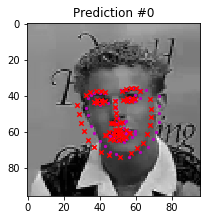

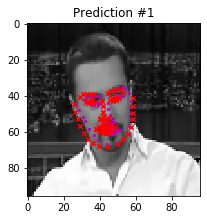

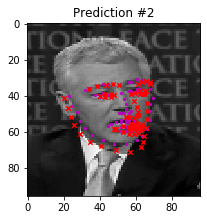

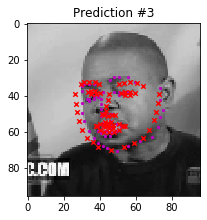

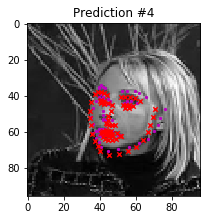

In [31]:
############################################################################################
# Predict
############################################################################################

n_samples = 5

for i in range(n_samples):
    
    # define the size of images
    fig = plt.figure(figsize=(18,12))
    
    # randomly select a sample
    idx = np.random.randint(0, len(valid_data))
    sample = valid_data[idx]
    
    ax = plt.subplot(1, n_samples, i + 1)
    ax.set_title('Prediction #{}'.format(i))
                 
    image_path, key_pts = sample
    
    image = plt.imread(image_path)
    
    h, w = image.shape[:2]

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    for t in valid_transformations:
        image_copy, key_pts_copy = t(image_copy, key_pts_copy)

    key_pts_pred = model.predict(image_copy[np.newaxis,...]) 
    
    key_pts_pred = denormalize_key_pts(np.squeeze(key_pts_pred),image_copy.shape[:2])

    plt.imshow(np.squeeze(image_copy), cmap = 'gray')
    plt.scatter(key_pts_copy[:, 0], key_pts_copy[:, 1], s=20, marker='.', c='m')
    plt.scatter(key_pts_pred[:, 0], key_pts_pred[:, 1], s=20, marker='x', c='r')
    

In [32]:
############################################################################################
# Video Testing
############################################################################################    

In [64]:
video_folder = 'videos'

# Class for detecting key points on a video
class KeyPtsDetector():
    
    def __init__(self,  xy_origin = (0,0), crop_size=(96,96), patch_size = (96,96)):
    
        self.crop_size = crop_size
        self.patch_size = patch_size
        self.xy_origin = xy_origin
       
    def process_frame(self,image):
    
        x, y = self.xy_origin
        
        # Crop video from starting point
        cropped_image = image[y:y+self.crop_size[1] ,x:x+self.crop_size[0]]
        
        # Resize to fit the model input
        scaled_image = cv2.resize(cropped_image,self.patch_size)
        
        #Convert image to gray scale
        gray = cv2.cvtColor(scaled_image,cv2.COLOR_RGB2GRAY)
        
        gray = np.expand_dims(gray, axis=-1)
            
        # Predict value using model
        key_pts = model.predict(gray[np.newaxis,...])
        
        # Denormilize from [-1,1] to the normal size again
        key_pts = denormalize_key_pts(np.squeeze(key_pts),scaled_image.shape[:2])
        
        # Convert to three channels
        gray = np.dstack((gray, gray, gray)) 
        
        # Draw Key Points
        for key_pt in key_pts:
            
            cv2.circle(gray,(key_pt[0],key_pt[1]),1,(0,255,0),1)
         
        return gray
    

In [ ]:
video_path_1 = os.path.join(video_folder,'0553_01_006_donald_trump.avi')

video = VideoFileClip(video_path_1)
video.reader.close()

kpt_detector = KeyPtsDetector()
kpt_detector.xy_origin = (40,0)
kpt_detector.crop_size = (200,200)
kpt_detector.patch_size = (96,96)

output_clip = video.fl_image(kpt_detector.process_frame) #NOTE: this function expects color images!!

# Save processed video clip
output_clip.write_videofile(os.path.join(video_folder,'video_test_1.mp4'),audio=False)


<img src="images/trump.gif" alt="Snow" style="width:40%">

In [ ]:
video_path_2 = os.path.join(video_folder,'0492_03_009_bill_gates.avi')

video = VideoFileClip(video_path_2)
video.reader.close()

kpt_detector = KeyPtsDetector()
kpt_detector.xy_origin = (120,0)
kpt_detector.crop_size = (200,200)
kpt_detector.patch_size = (96,96)

output_clip = video.fl_image(kpt_detector.process_frame) #NOTE: this function expects color images!!

# Save processed video clip
output_clip.write_videofile(os.path.join(video_folder,'video_test_2.mp4'),audio=False)

<img src="images/bill.gif" alt="Snow" style="width:40%">